# Week 3 Seminar.

## Chapter 4. Binary Classification & Logistic Regression. ISLR textbook.

### Course: ML, 2024/2025, HSE
### Author: Oleg Melnikov, Alexey Boldyrev, Teaching Team.

In this seminar we'll study the famous [Titanic](https://www.kaggle.com/c/titanic) dataset and apply Logistic Regression to predict passengers survival probability given a set of features we know about them.

Keywords: classification, classifier,overfitting, null, confusion matrix, sensitivity, specificity, ROC curve, AUC or area under the (ROC) curve.


In [ ]:
# let the statsmodels library to be consistent with latest pandas

# !pip -q install --upgrade statsmodels

In [ ]:
# We use same standard imports as in previous lab
# allows us to print multiple outputs from a single Colab cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# load important libraries that we might use
import numpy as np, pandas as pd, matplotlib.pylab as plt
import seaborn as sns, statsmodels.api as sm
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import r2_score

# Increase viewable area of Pandas tables, numpy arrays, plots
pd.set_option('display.max_rows', 15, 'display.max_columns', 500, 'display.max_colwidth', 1, 'display.precision', 2)
np.set_printoptions(linewidth=10000, precision=4, edgeitems=20, suppress=True)
plt.rcParams['figure.figsize'] = [10, 7]

# Intro to Logistic Regression

Logistic Regression is a **classification** model. It's very closely related to linear regression. For some class labels $y \in \{0, 1\}$ and some features $X$  logistic regression models the probability $Pr(y=1 | X)$

In the case of Titanic dataset, the labels are: 1 for survived, 0 otherwise. This is a typical binary classification task.

The model itself:

$$p(x) = \frac{e^{\beta_0 + \beta_1 x_1 + \beta_2 x_2 \dots }}{1 + e^{\beta_0 + \beta_1 x_1 + \beta_2 x_2 \dots }} = sigmoid(\beta_0 + \beta_1 x_1 + \beta_2 x_2 \dots)$$

In short, the model is simply [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) applied to the output of a linear model.

The output of the linear model is called [*log-odds*](https://en.wikipedia.org/wiki/Logit) (also *logits*) $$\beta_0 + \beta_1 x_1 + \beta_2 x_2 \dots = log(\frac{p(x)}{1-p(x)})$$

The sigmoid function turns the log-odds (output from the linear model) into probabilities, so the output of the model is always on the range of $[0, 1]$.

Logistic Regression is not fit using OLS, but via maximum likelihood estimation by optimizing [negative loglikelihood ](https://towardsdatascience.com/log-loss-function-math-explained-5b83cd8d9c83). Usually the optimization is done with gradient descent.

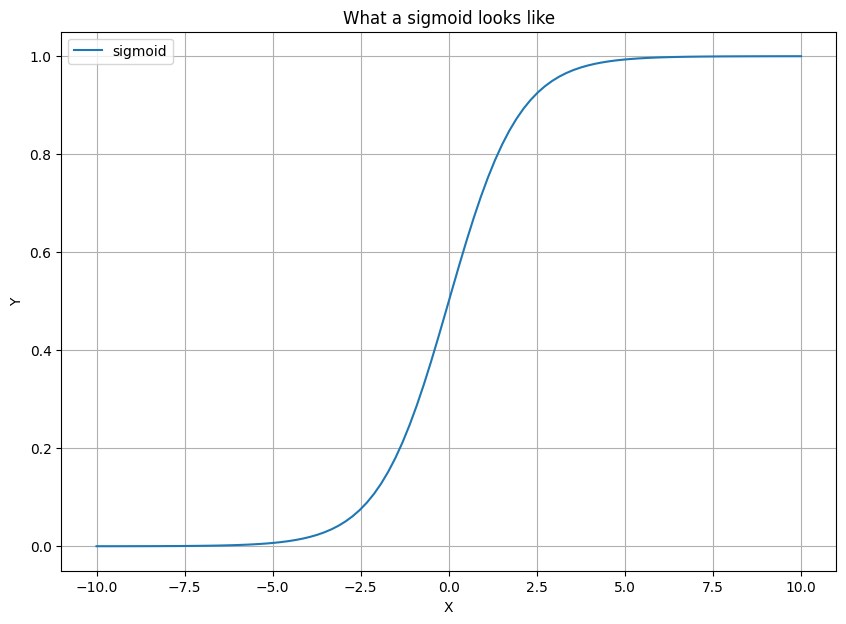

In [ ]:
def sigmoid(x):
    return np.exp(x) / (1 + np.exp(x))

x_vals = np.linspace(-10, 10, 100)
y_vals = sigmoid(x_vals)

plt.figure();
plt.plot(x_vals, y_vals, label='sigmoid');
plt.xlabel('X');
plt.ylabel('Y');
plt.title('What a sigmoid looks like');
plt.legend();
plt.grid();
plt.show();


# Data Loading & Analysis

Let's follow the standard protocol and use `.read_csv` method to load required dataframe:

In [ ]:
# assign file path to a variable
# csv_url = 'http://web.stanford.edu/~oleg2/data/stats216/ch4/Titanic_Kaggle.csv'
# df = pd.read_csv(csv_url)
# df.head()

csv_url = 'https://raw.githubusercontent.com/omelnikov/data/main/titanic/titanic.csv'
df = pd.read_csv(csv_url)
df = df.drop('PassengerId', axis=1)
df.rename(columns={'Survived': 'srv', 'Pclass': 'cls', 'Name': 'name', 'Sex': 'sex',
                   'Age': 'age', 'SibSp': 'sibsp', 'ParCh': 'parch', 'Ticket': 'tkt',
                   'Fare': 'fare', 'Cabin': 'cabin', 'Embarked': 'emb', }, inplace=True)
df.sex = 1*(df.sex=='female')  # Make binary variable from categorical variable "sex": 1-female, 0-male
df.head()

,srv,cls,name,sex,age,sibsp,parch,tkt,fare,cabin,emb
0,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.25,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",1,38.0,1,0,PC 17599,71.28,C85,C
2,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.92,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.10,C123,S
4,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.05,NaN,S


The loaded data has the following features:

 - `srv` - target variable, which indicates survival (1 = survived).
 - `cls` - ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
 - `age`
 - `sibsp` - \# of siblings / spouses aboard the Titanic
 - `parch` - \# of parents / children aboard the Titanic
 - `fare` - Passenger fare
 - `sex` - gender (1 = female, 0 = male)
 - `emb` - Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)
 - `cabin` - Cabin number
 - `tkt` - Ticket number
 - `name` - Passenger's name

By analysing our data with `.info` and `.describe` methods, we see that:
* There's only one binary feature `sex` and target `srv` is also binary
* `cabin` appears mostly missing, and there are some NA values for `age` as well
* `sibsp`, `parch` and `fare` deviate a lot around their means - we might have outliers and leverage points due to this
* `tkt` is mostly numeric, but can contain some codes


In [ ]:
df.info()  # Get a standard report of feature types, shape and NA values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   srv     891 non-null    int64  
 1   cls     891 non-null    int64  
 2   name    891 non-null    object 
 3   sex     891 non-null    int64  
 4   age     714 non-null    float64
 5   sibsp   891 non-null    int64  
 6   parch   891 non-null    int64  
 7   tkt     891 non-null    object 
 8   fare    891 non-null    float64
 9   cabin   204 non-null    object 
 10  emb     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


In [ ]:
df.describe()  # Get statistics for non-object features

,srv,cls,sex,age,sibsp,parch,fare
count,891.00,891.00,891.00,714.00,891.00,891.00,891.00
mean,0.38,2.31,0.35,29.70,0.52,0.38,32.20
std,0.49,0.84,0.48,14.53,1.10,0.81,49.69
min,0.00,1.00,0.00,0.42,0.00,0.00,0.00
25%,0.00,2.00,0.00,20.12,0.00,0.00,7.91
50%,0.00,3.00,0.00,28.00,0.00,0.00,14.45
75%,1.00,3.00,1.00,38.00,1.00,0.00,31.00
max,1.00,3.00,1.00,80.00,8.00,6.00,512.33


In [ ]:
df.describe(include=['O'])  # Get statistics for object features

,name,tkt,cabin,emb
count,891,891,204,889
unique,891,681,147,3
top,"Braund, Mr. Owen Harris",347082,B96 B98,S
freq,1,7,4,644


We can also get individual feature values & frequences for categorical columns using a `pd.value_counts` function:

In [ ]:
for feature in ['srv', 'cls', 'sex', 'emb']:  # Iterate over features
    print("Statistics for feature", feature)
    print(pd.value_counts(df[feature], normalize=True))  # Show value densities
    print("")

Statistics for feature srv
srv
0    0.62
1    0.38
Name: proportion, dtype: float64

Statistics for feature cls
cls
3    0.55
1    0.24
2    0.21
Name: proportion, dtype: float64

Statistics for feature sex
sex
0    0.65
1    0.35
Name: proportion, dtype: float64

Statistics for feature emb
emb
S    0.72
C    0.19
Q    0.09
Name: proportion, dtype: float64



<ipython-input-8-098b09a02367>:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  print(pd.value_counts(df[feature], normalize=True))  # Show value densities


There is a bias towards men gender, and most of the passengers appear to embark in Southampton port.

Also, we see there's a little imbalance in targets.

***It is extremely important to study the distribution of targets in classification task!***

For example, if the fraction of survived passengers is close to 95%, it indicates that even the simplest model returning 1 regardless of the input would get an accuracy of 95%. Therefore, this default metric would be inappropriate for measuring model performance, and we would need to choose a different one.

In our data it's not the case - therefore we can safely measure performance with accuracy score.


Let's also check that our `name` column matches gender.

To do this, we note that `name` often has a form like “last, Mr/Mrs/Miss. First (some other name)”.

Thus, we can filter only rows that have a particular gender and extract titles from their names:

In [ ]:
def get_title(full_name):
    # Extract title from the full name.
    # Assumes it has the form of `last, Mr/Mrs/Miss. First`
    name = full_name.split(", ")[1]
    title = name.split(".")[0]
    return title

women_df = df[df['sex'] == 1] # Get women-only rows

# Applies function for each row in df
women_titles = women_df['name'].apply(get_title)
pd.value_counts(women_titles) # Reports statistics of titlbes

<ipython-input-9-8d3a40af334b>:12: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(women_titles) # Reports statistics of titlbes


,count
name,
Miss,182
Mrs,125
Mlle,2
Mme,1
Ms,1
Lady,1
the Countess,1
Dr,1


In [ ]:
men_df = df[df['sex'] == 0] # Get men-only rows
# Applies function for each row in df
men_titles = men_df['name'].apply(get_title)
pd.value_counts(men_titles) # Reports statistics of titles

<ipython-input-10-b87f459d22d4>:4: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(men_titles) # Reports statistics of titles


,count
name,
Mr,517
Master,40
Rev,6
Dr,6
Major,2
Col,2
Don,1
Sir,1
Capt,1


Aside from a few examples, our understanding is correct - women usually have titles "Miss" and "Mrs", while men have titles "Mr" and "Master".

# Data Statistics

Similarly to linear regression, we might want to check correlations between
features, as they would show us whether we have any multicollinearity isssues:

**Takeaways:**
* Our target `srv` has the strongest correlation with `sex` feature. Nevertheless, it's pretty close to 0.5, which means it may be benefitial to go beyond a simple logistic model.
* Unsurprisingly, there is a negative correlation between `fare` and `cls`. The higher the class (i.e. the lower `cls` value), the more it would cost.
* Overall, it doesn't look like we have strong correlations between features.

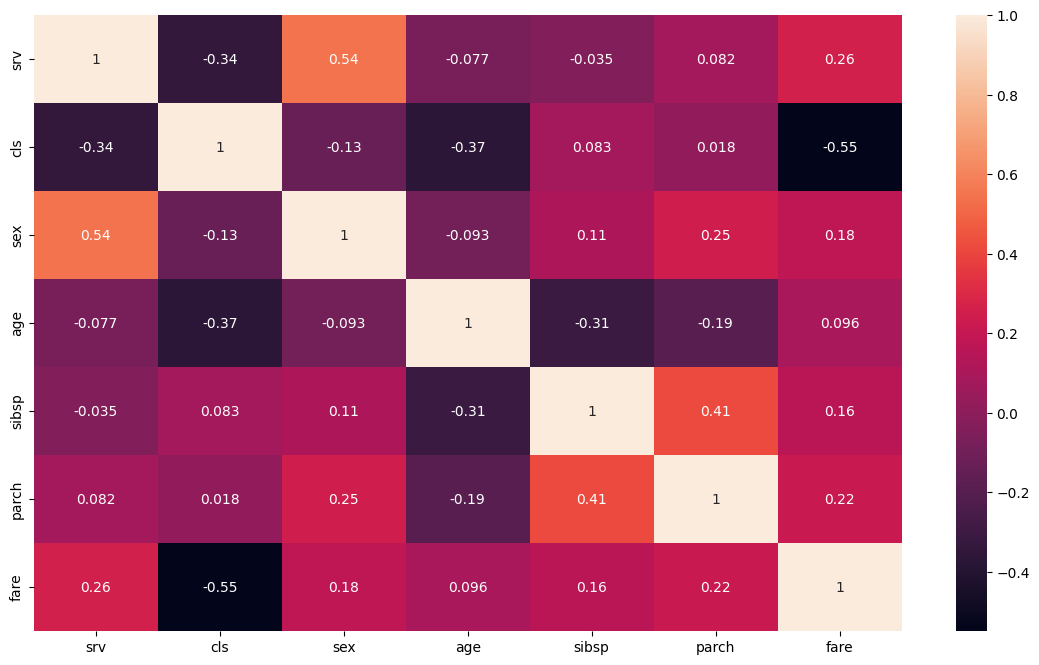

In [ ]:
plt.figure(figsize=(14,8));
ax = sns.heatmap ( df.corr(numeric_only=True) , annot=True);

Additionally, it may be beneficial to study pairwise distributions of categorical features with our target variable. We can do this with a `sns.barplot` function:

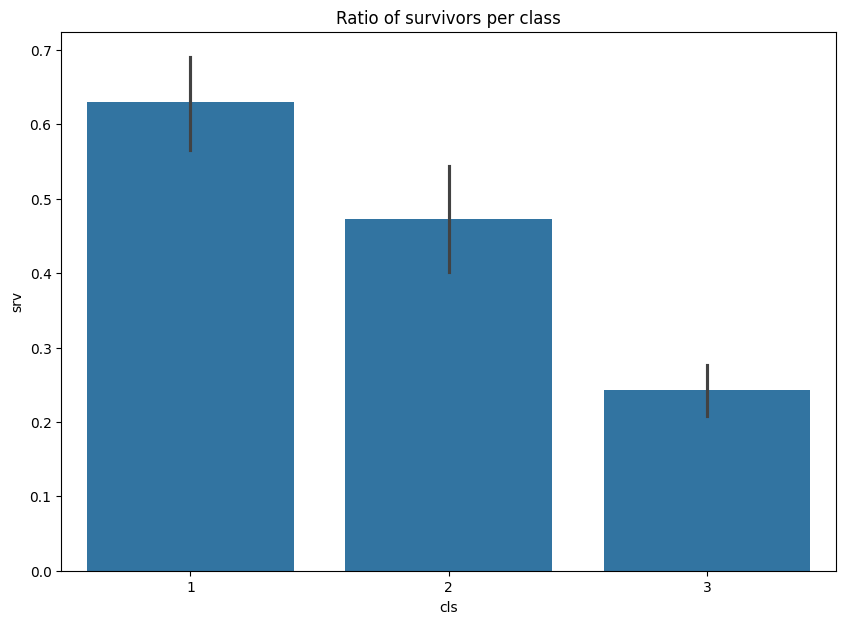

In [ ]:
sns.barplot(x=df['cls'], y=df['srv'])  # Plot average & intervals of survival rate for every class
plt.title('Ratio of survivors per class');

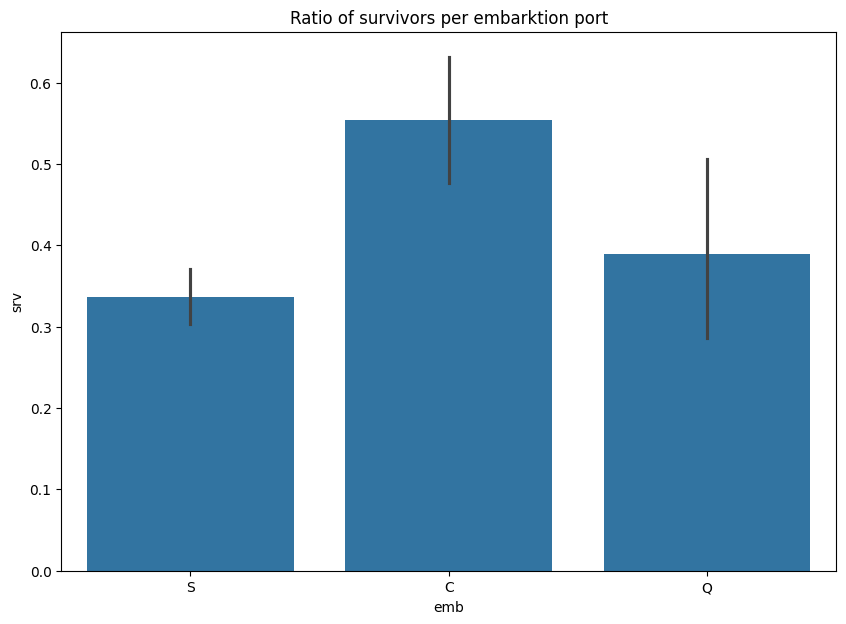

In [ ]:
sns.barplot(x=df['emb'], y=df['srv'])  # Same with embarkation port
plt.title('Ratio of survivors per embarktion port');

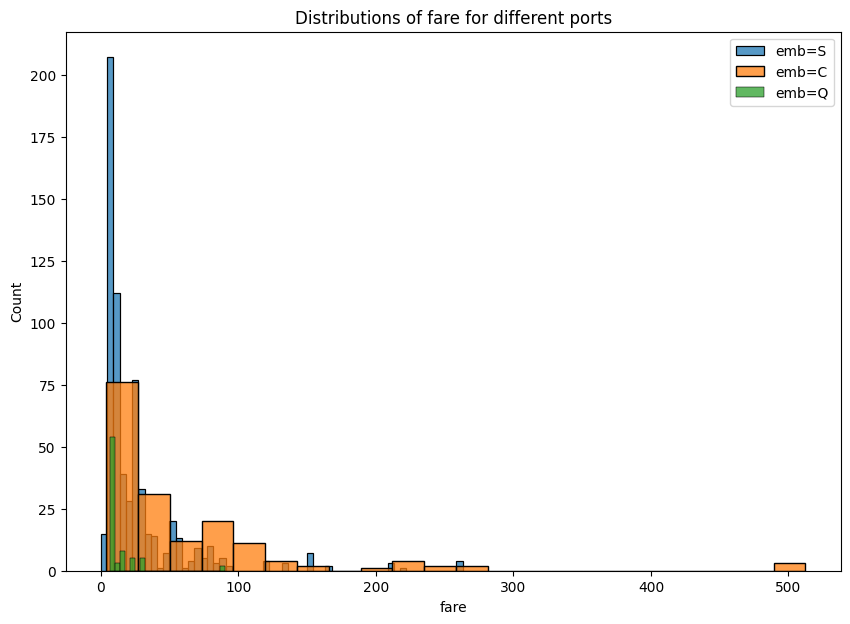

In [ ]:
sns.histplot(df[df['emb'] == 'S']['fare'], label='emb=S')
sns.histplot(df[df['emb'] == 'C']['fare'], label='emb=C')
sns.histplot(df[df['emb'] == 'Q']['fare'], label='emb=Q')
plt.xlabel('fare')
plt.title('Distributions of fare for different ports')
plt.legend();

We can see that passengers from the 3rd class has a much lower chance of survival than the ones from the 1st class. Also, embarking at Cherbourg would you give slightly more chances to survive.

# Preprocessing

Once we got some insights about our data, we may switch to fitting Logistic Regression model. Before doing this however, we need to:

* Deal with object (i.e. non-numerical) features (`emb`, `cabin`, `tkt` and `name` columns in our case)
* Drop or find a way to fill in missing (NA) values

Let's solve the first problem:

In [ ]:
# Ignore cabin & ticket numbers, as well as passenger name for prediciton
df_filtered = df.drop(['cabin', 'tkt', 'name'], axis=1)

# Use a product trick to convert categorical features `emb`
# with three posible values to two binary features
df_filtered["emb_is_S"] = (df_filtered["emb"] == "S").astype(int)
df_filtered["emb_is_C"] = (df_filtered["emb"] == "C").astype(int)

# Drop unnecessary feature - we can derive it from `emb_is_S` or `emb_is_C`
df_filtered = df_filtered.drop(["emb"], axis=1)

df_filtered.sample()

,srv,cls,sex,age,sibsp,parch,fare,emb_is_S,emb_is_C
123,1,2,1,32.5,0,0,13.0,1,0


In [ ]:
# Alternatively we can just use a pandas builtin function pd.get_dummies
emb_cols = pd.get_dummies(df['emb'], prefix='emb', drop_first=True)
emb_cols.head()

,emb_Q,emb_S
0,False,True
1,False,False
2,False,True
3,False,True
4,False,True


In [ ]:
df_filtered.head()

,srv,cls,sex,age,sibsp,parch,fare,emb_is_S,emb_is_C
0,0,3,0,22.0,1,0,7.25,1,0
1,1,1,1,38.0,1,0,71.28,0,1
2,1,3,1,26.0,0,0,7.92,1,0
3,1,1,1,35.0,1,0,53.10,1,0
4,0,3,0,35.0,0,0,8.05,1,0


In [ ]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   srv       891 non-null    int64  
 1   cls       891 non-null    int64  
 2   sex       891 non-null    int64  
 3   age       714 non-null    float64
 4   sibsp     891 non-null    int64  
 5   parch     891 non-null    int64  
 6   fare      891 non-null    float64
 7   emb_is_S  891 non-null    int64  
 8   emb_is_C  891 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 62.8 KB


 Once we made our features numerical, the question is - How do we deal with NA values?

#### Show answers (after you gave it a try!)


* Numeric columns can be imputed with column means or medians.
* Non-numerics can be imputed with medians (mean will not work here)
* We can also use group averages. For example, age and ticket price may correlate suggesting that age should be a (simple or complex) function of price and, perhaps, some other parameters.
* If we can locate members of the same family with partially missing cabin values, we could assume that they all stayed in the same cabin.


#### For the sake of simplicity, currently we're going to follow the first approach:


In [ ]:
median_age = df_filtered["age"].median()

print("Filling NA values with age", median_age)

df_filtered = df_filtered.fillna(median_age)
df_filtered.sample(5)

Filling NA values with age 28.0


,srv,cls,sex,age,sibsp,parch,fare,emb_is_S,emb_is_C
225,0,3,0,22.0,0,0,9.35,1,0
271,1,3,0,25.0,0,0,0.00,1,0
312,0,2,1,26.0,1,1,26.00,1,0
95,0,3,0,28.0,0,0,8.05,1,0
559,1,3,1,36.0,1,0,17.40,1,0


In [ ]:
df_filtered.iloc[200:205, :]

,srv,cls,sex,age,sibsp,parch,fare,emb_is_S,emb_is_C
200,0,3,0,28.0,0,0,9.50,1,0
201,0,3,0,28.0,8,2,69.55,1,0
202,0,3,0,34.0,0,0,6.50,1,0
203,0,3,0,45.5,0,0,7.22,0,1
204,1,3,0,18.0,0,0,8.05,1,0


In [ ]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   srv       891 non-null    int64  
 1   cls       891 non-null    int64  
 2   sex       891 non-null    int64  
 3   age       891 non-null    float64
 4   sibsp     891 non-null    int64  
 5   parch     891 non-null    int64  
 6   fare      891 non-null    float64
 7   emb_is_S  891 non-null    int64  
 8   emb_is_C  891 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 62.8 KB


We see that now all features are numerical and there are no NA values.

#### Outliers

Last, but not least, we may want to deal with outliers before fitting our model. The reason is, similarly to linear regression, both target outliers and leverage points can significantly shift our coefficient estimates and the confidence of prediction. We can visually check their existance with `sns.boxplot` function:

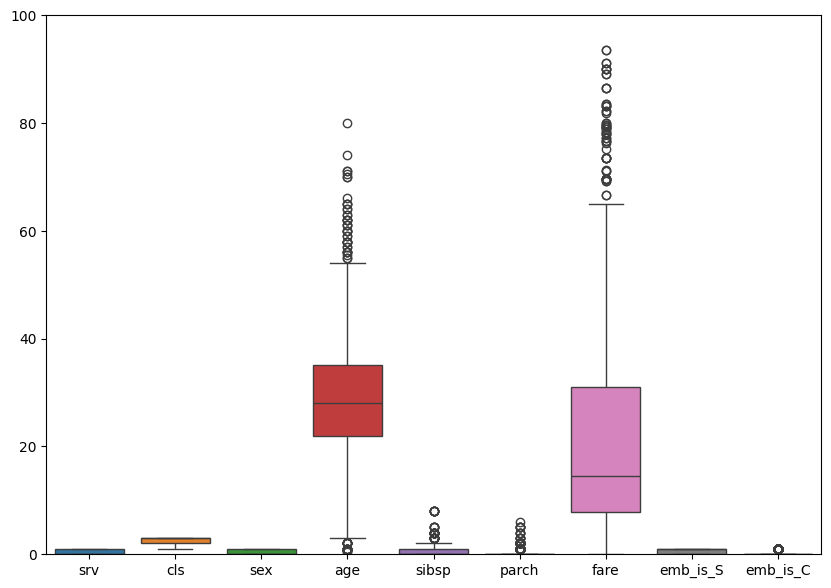

In [ ]:
sns.boxplot(data=df_filtered)
plt.ylim(0, 100);

We see that both `sibsp` and `fare` columns contain a significant number of outliers. For simplicity, let's map them to 95% percentile for now:

In [ ]:
fare_max = df_filtered['fare'].quantile(0.95)  # extract 95% percentile of fare

df_filtered.loc[df_filtered['fare'] > fare_max, "fare"] = fare_max  # replace too high values with percentile
df_filtered.head()

,srv,cls,sex,age,sibsp,parch,fare,emb_is_S,emb_is_C
0,0,3,0,22.0,1,0,7.25,1,0
1,1,1,1,38.0,1,0,71.28,0,1
2,1,3,1,26.0,0,0,7.92,1,0
3,1,1,1,35.0,1,0,53.10,1,0
4,0,3,0,35.0,0,0,8.05,1,0


In [ ]:
sibsp_max = df_filtered['sibsp'].quantile(0.95)  # extract 95% percentile of sibsp

df_filtered.loc[df_filtered['sibsp'] > sibsp_max, "sibsp"] = fare_max  # replace too high values with percentile
df_filtered.sample()

<ipython-input-24-31ec80cc4d01>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '112.07915' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_filtered.loc[df_filtered['sibsp'] > sibsp_max, "sibsp"] = fare_max  # replace too high values with percentile


,srv,cls,sex,age,sibsp,parch,fare,emb_is_S,emb_is_C
653,1,3,1,28.0,0.0,0,7.83,0,0


# Fitting Logistic Regression

After analysing and preprocessing our data, we can finally switch to solving binary classification task with Logistic Regression model.

For this, we're going to use `sm.Logit` class, that basically works the same way as `sm.OLS` but assumes labels are binary and not continuous. Then, we'll measure the accuracy of classifier on a hold-out test set and also get a confusion matrix for our predictive model:

In [ ]:
X_train, X_test, y_train, y_test = tts(
    df_filtered.drop(["srv"], axis=1), df_filtered["srv"], test_size=0.2,
    random_state=0
)  # Split data onto train and test subsets

print("Train: input shape is ", X_train.shape, "output shape is ", y_train.shape)
print("Test: input shape is ", X_test.shape, "output shape is ", y_test.shape)
print("Unique values of targets (should be 0 or 1):", np.unique(y_train))

Train: input shape is  (712, 8) output shape is  (712,)
Test: input shape is  (179, 8) output shape is  (179,)
Unique values of targets (should be 0 or 1): [0 1]


In [ ]:
from sklearn.metrics import accuracy_score

# Add a column with ones to use bias coeff
mdl = sm.Logit(y_train, sm.add_constant(X_train))
# Fit our model on training data
fmdl = mdl.fit()

# Get prediction scores on test data
pr_test_scores = fmdl.predict(sm.add_constant(X_test))
# Predict 1 if score (= probability) above 0.5, and 0 otherwise
y_predicted = (pr_test_scores > 0.5)

# Measure accuracy relative to ground truth
print("Trained accuracy score is %.3f" % accuracy_score(y_test, y_predicted))

Optimization terminated successfully.
         Current function value: 0.448391
         Iterations 6
Trained accuracy score is 0.816


Note that `.fit` method reports the amount of iterations before convergence. It's because we can't get the exact solution for our problem, so we need to optimize coefficients iteratively. However, we can still get many useful statistics with a `.summary` method:

In [ ]:
print(fmdl.summary())

                           Logit Regression Results                           
Dep. Variable:                    srv   No. Observations:                  712
Model:                          Logit   Df Residuals:                      703
Method:                           MLE   Df Model:                            8
Date:                Fri, 20 Sep 2024   Pseudo R-squ.:                  0.3265
Time:                        07:22:06   Log-Likelihood:                -319.25
converged:                       True   LL-Null:                       -473.99
Covariance Type:            nonrobust   LLR p-value:                 3.963e-62
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8207      0.755      3.738      0.000       1.342       4.300
cls           -1.1084      0.186     -5.967      0.000      -1.472      -0.744
sex            2.5989      0.219     11.854      0.0

The largest p-values are reported for `fare` and `emb_is_C` features. This may indicate their redundancy (the latter one) or the need to adjust outliers even further (the former).

Finally, we can plot the **confusion matrix** of our test predictions.

![image.png](https://glassboxmedicine.files.wordpress.com/2019/02/confusion-matrix.png?w=816)

Confusion matrix is a necessary tool for analyzing a classifier performance.

It allows us to compute [different metrics of performance](https://en.wikipedia.org/wiki/Precision_and_recall) such as:

**Precision**: $TP/ (TP + FP)$

**Recall**: $TP / (TP + FN)$

**Accuracy**: $(TP + TN)/(TP + TN + FP + FN)$

[**Balanced accuracy** (resistant to class imbalance)](https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score)

**Task**: Come up with such values for TP, TN, FP, FN, such that the model is very bad, but the accuracy is nearly $1.0$?


Let's obtain a confusion matrix for our test predictions using Python.

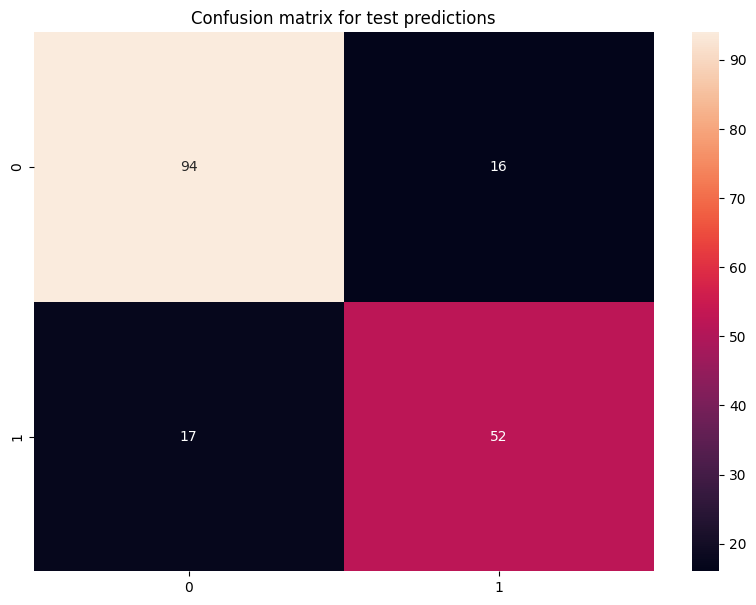

In [ ]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_predicted), annot=True)
plt.title('Confusion matrix for test predictions');

We can also obtain a normalized version of it.

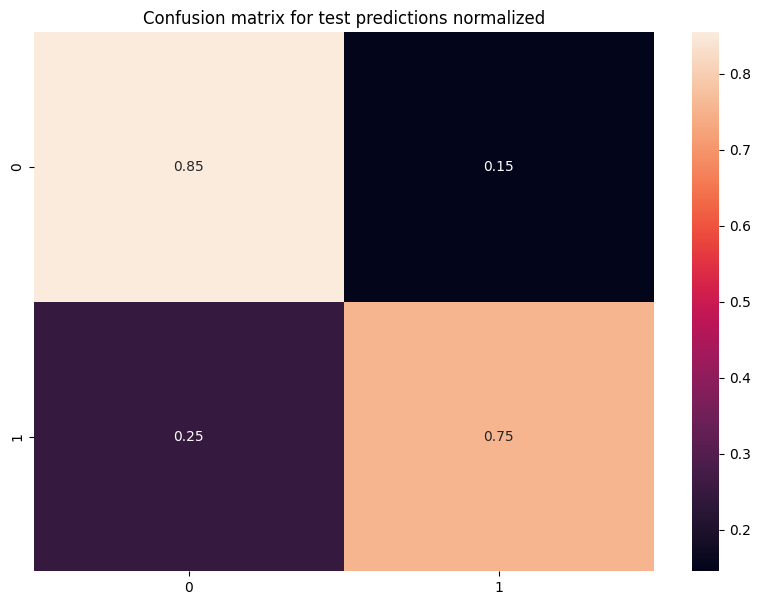

In [ ]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, y_predicted, normalize='true'), annot=True)
plt.title('Confusion matrix for test predictions normalized');


Here, the columns correspond to predicted classes while rows correspond to ground truth labels, and we measure the accuracy in predicting a certain class. E.g. the first row second column has a value of 0.15, which means that 15% of lost passengers would be reported as survived by our model.

# Choosing the right classification threshold

Logistic Regression outputs probabilities, but we are interested in predicting classes. The simple solution is to threshold probabilities at $0.5$ as we did earlier. If the probability is $>= 0.5$ we predict class $1$.

But for some tasks you might want different thresholds. If you are classifying whether bank clients will default or not, you might want to act whenever the probability of default is over $0.2$. If, on the other hand, the action you take if a model predicts $1$ is very expensive, you might want to set the threshold at $0.9$ so that you only act when you are very sure you need to.

If you just want the best accuracy score, you want to try different thresholds and see which does best.

Let's try some classification thresholds:

In [ ]:
pr_test_scores = fmdl.predict(sm.add_constant(X_test))
y_predicted = (pr_test_scores > 0.5)
print("Accuracy score for threshold 0.5 is %.3f" % accuracy_score(y_test, y_predicted))
print("Accuracy score for threshold 0.1 is %.3f" % accuracy_score(y_test, (pr_test_scores > 0.1)))
print("Accuracy score for threshold 0.9 is %.3f" % accuracy_score(y_test, (pr_test_scores > 0.9)))
print("Accuracy score for threshold 0.7 is %.3f" % accuracy_score(y_test, (pr_test_scores > 0.6)))

Accuracy score for threshold 0.5 is 0.816
Accuracy score for threshold 0.1 is 0.531
Accuracy score for threshold 0.9 is 0.715
Accuracy score for threshold 0.7 is 0.804


In [ ]:
pr_test_scores

,0
495,0.13
648,0.09
278,0.06
31,0.95
255,0.61
...,...
780,0.79
837,0.09
215,0.94
833,0.11


**Task:** Plot accuracies for different thresholds below to find the best threshold. Output the best threshold and accuracy.

In [ ]:
thresholds = np.linspace(0, 1, 100)
thresholds

array([0.    , 0.0101, 0.0202, 0.0303, 0.0404, 0.0505, 0.0606, 0.0707, 0.0808, 0.0909, 0.101 , 0.1111, 0.1212, 0.1313, 0.1414, 0.1515, 0.1616, 0.1717, 0.1818, 0.1919, 0.202 , 0.2121, 0.2222, 0.2323, 0.2424, 0.2525, 0.2626, 0.2727, 0.2828, 0.2929, 0.303 , 0.3131, 0.3232, 0.3333, 0.3434, 0.3535, 0.3636, 0.3737, 0.3838, 0.3939, 0.404 , 0.4141, 0.4242, 0.4343, 0.4444, 0.4545, 0.4646, 0.4747, 0.4848, 0.4949, 0.5051, 0.5152, 0.5253, 0.5354, 0.5455, 0.5556, 0.5657, 0.5758, 0.5859, 0.596 , 0.6061, 0.6162, 0.6263, 0.6364, 0.6465, 0.6566, 0.6667, 0.6768, 0.6869, 0.697 , 0.7071, 0.7172, 0.7273, 0.7374, 0.7475, 0.7576, 0.7677, 0.7778, 0.7879, 0.798 , 0.8081, 0.8182, 0.8283, 0.8384, 0.8485, 0.8586, 0.8687, 0.8788, 0.8889, 0.899 , 0.9091, 0.9192, 0.9293, 0.9394, 0.9495, 0.9596, 0.9697, 0.9798, 0.9899, 1.    ])

In [ ]:
accuracy_score(y_test, (pr_test_scores > thresholds[5]))

0.41899441340782123

In [ ]:
accuracies = [accuracy_score(y_test, (pr_test_scores > x)) for x in thresholds]
accuracies = np.array(accuracies)
accuracies

array([0.3855, 0.3855, 0.3855, 0.4022, 0.4134, 0.419 , 0.4302, 0.4302, 0.4413, 0.4525, 0.5363, 0.5642, 0.581 , 0.6257, 0.6592, 0.676 , 0.7095, 0.7151, 0.7095, 0.7207, 0.7263, 0.7263, 0.7263, 0.7374, 0.7486, 0.7486, 0.7598, 0.7765, 0.7821, 0.7821, 0.7877, 0.7933, 0.7933, 0.7989, 0.7989, 0.8045, 0.7989, 0.7989, 0.7989, 0.8045, 0.8045, 0.8045, 0.8045, 0.8045, 0.8101, 0.8156, 0.8101, 0.8156, 0.8156, 0.8156, 0.8156, 0.8156, 0.8101, 0.8101, 0.8101, 0.8101, 0.8101, 0.8101, 0.8101, 0.8045, 0.7989, 0.7933, 0.7877, 0.7877, 0.7877, 0.7821, 0.7877, 0.7877, 0.7877, 0.7821, 0.7765, 0.7821, 0.7877, 0.7877, 0.7877, 0.7877, 0.7877, 0.7933, 0.7877, 0.7877, 0.7933, 0.7654, 0.7654, 0.7598, 0.7486, 0.7374, 0.7318, 0.7318, 0.7263, 0.7151, 0.6872, 0.6816, 0.6704, 0.6592, 0.6369, 0.6201, 0.6145, 0.6145, 0.6145, 0.6145])

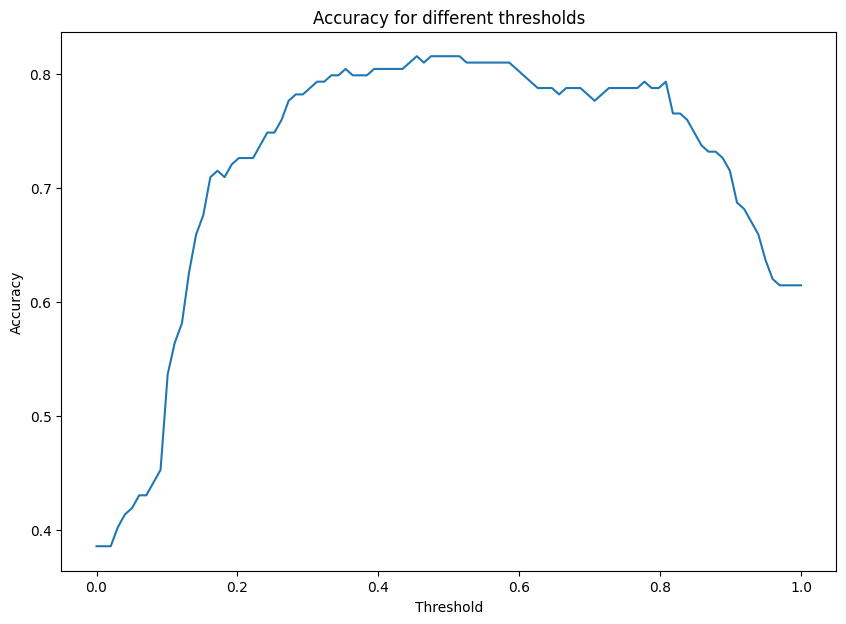

In [ ]:
plt.figure()
plt.plot(thresholds, accuracies)
plt.title('Accuracy for different thresholds')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.show();

# print('Best accuracy:', )
# print('Best threshold:', )

# ROC Curve and the AUC metric

It appears the performance of the model is dependent on the selected classification threshold. But how do we analyze how good our model is regardless of the threshold?

Some models will be better than other models regardless of the threshold. When we add features to a model, we want to see if it gets better across all thresholds.

The [ROC curve](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html) plots the True Positive Rate against the False Positive Rate for every classification threshold.

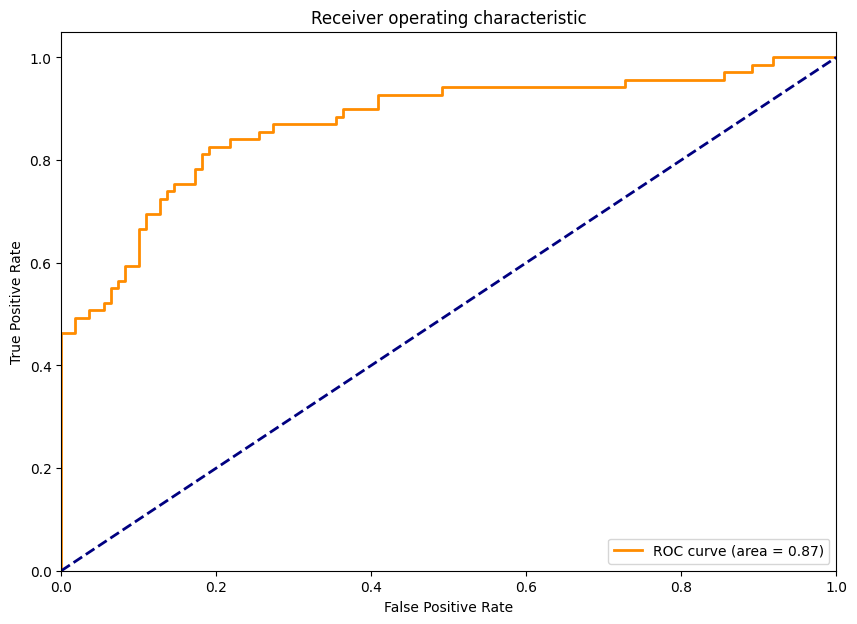

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

y_score = fmdl.predict(sm.add_constant(X_test))

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show();

The closer the curve is to the upper left, the better the classifier.

Which means that the bigger the area under the curve (AUC), the better the classifier. We can use it as a numeric measure of performance **regardless of selected threshold**.

# Why don't we just use Linear Regression?

Simple linear regression also gives good accuracy score. But it's not the best choice here...

In [ ]:
mdl = sm.OLS(y_train, sm.add_constant(X_train))     # training on train observations
fmdl = mdl.fit()

# Get prediction scores on test data
pr_test_scores = fmdl.predict(sm.add_constant(X_test))

# Predict 1 if score (= probability) above 0.5, and 0 otherwise
y_predicted = (pr_test_scores > 0.5)

# Measure accuracy relative to ground truth
print("Trained accuracy score is %.3f" % accuracy_score(y_test, y_predicted))

Trained accuracy score is 0.804


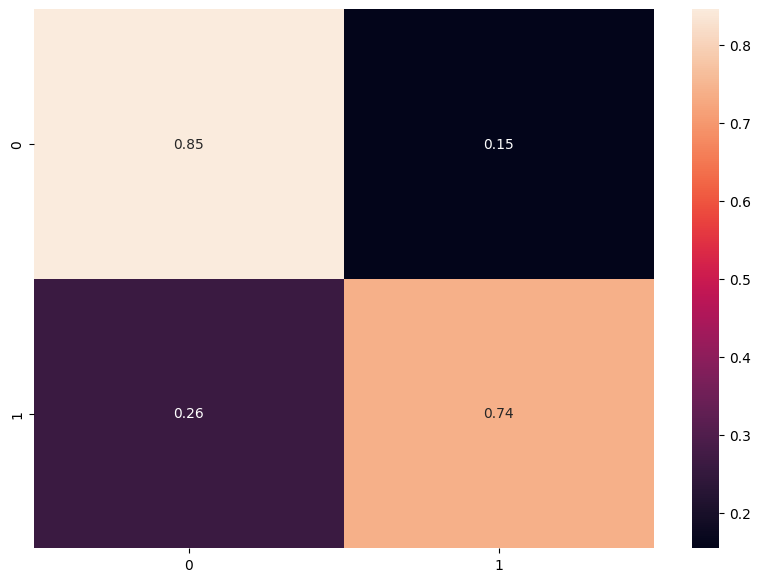

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_predicted, normalize='true'), annot=True);

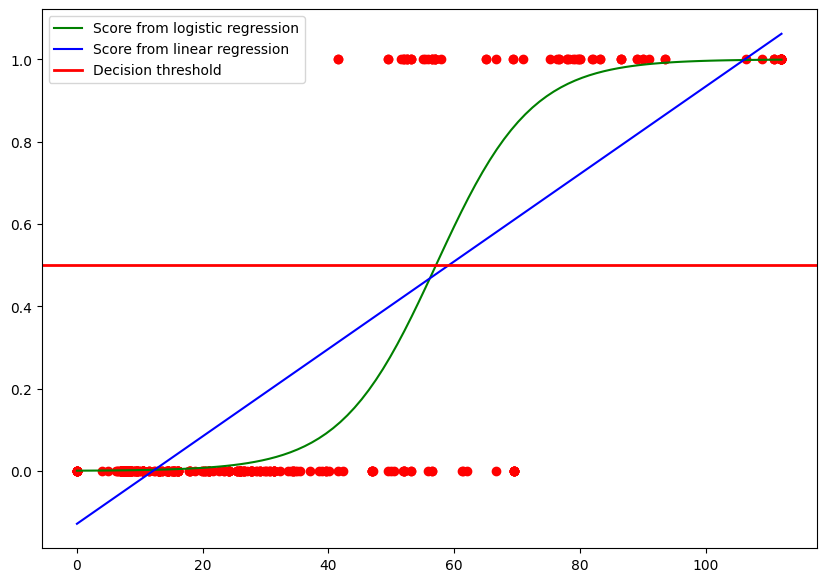

In [ ]:
x_var = 'fare'

# for the sake of interpretability
idx_drop = ((X_train.loc[:, x_var] < 40) & (y_train == 1)) | ((X_train.loc[:, x_var] > 70) & (y_train == 0))

xx_train = X_train.loc[~idx_drop, x_var].values.reshape(-1, 1)
x_grid = np.linspace(xx_train.min(), xx_train.max(), 100).reshape(-1, 1)

# logistic regression prediction
mdl = sm.Logit(y_train[~idx_drop], sm.add_constant(xx_train))     # training on train observations
fmdl = mdl.fit(disp=0)
pr_test_logit = fmdl.predict(sm.add_constant(x_grid))

plt.plot(x_grid, pr_test_logit, color='green', label='Score from logistic regression')

# linear regression prediction
mdl = sm.OLS(y_train[~idx_drop], sm.add_constant(xx_train))     # training on train observations
fmdl = mdl.fit()
pr_test_linreg = fmdl.predict(sm.add_constant(x_grid))
plt.plot(x_grid, pr_test_linreg, color='blue', label='Score from linear regression');
plt.axhline(0.5, color='r', linewidth=2, label='Decision threshold');
plt.scatter(xx_train, y_train[~idx_drop], c='r');
plt.legend();
plt.show();

In [ ]:
fmdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    srv   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     1150.
Date:                Fri, 20 Sep 2024   Prob (F-statistic):          9.65e-132
Time:                        07:49:44   Log-Likelihood:                 77.401
No. Observations:                 502   AIC:                            -150.8
Df Residuals:                     500   BIC:                            -142.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1285      0.013    -10.028      0.000      -0.154      -0.103
x1             0.0106      0.000     33.915      0.000       0.010       0.011
==============================================================================
Omnibus:                       38.456   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              122.354
Skew:                           0.284   Prob(JB):                     2.70e-27
Kurtosis:                       5.351   Cond. No.                         56.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Forward selection

In [ ]:
def forward_selected(X_train, y_train, X_test, y_test,
                     n_max_features=3, criteria='aic'):
    """Linear model designed by forward selection.
    Parameters:
    -----------
    Returns:
    --------
    model: an "optimal" fitted statsmodels logit model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(X_train.columns)
    selected = []
    current_score, best_new_score = -10**6, -10**6

    while (remaining and current_score == best_new_score) and (len(selected) < n_max_features):

        scores_with_candidates = []
        for candidate in remaining:

            current_features = selected + [candidate]
            mdl = sm.Logit(y_train, sm.add_constant(X_train[current_features]))
            fmdl = mdl.fit(disp=0)

            if criteria == 'accuracy':
              pr_test_scores = fmdl.predict(sm.add_constant(X_test[current_features]))
              y_predicted = (pr_test_scores > 0.5)
              score = accuracy_score(y_test, y_predicted)

            elif criteria == 'aic': score = -fmdl.aic
            scores_with_candidates.append((score, candidate))

        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()

        if current_score <= best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score

            print("# features selected = {}, score = {:.8f}".format(len(selected), current_score))
            print("Selected features: ", selected)
            print('')
    model = sm.Logit(y_train, sm.add_constant(X_train[selected])).fit(disp=0)
    return model

best_model = forward_selected(X_train, y_train, X_test, y_test,
                              n_max_features=10, criteria='accuracy')
print(best_model.summary())

# features selected = 1, score = 0.78770950
Selected features:  ['sex']

# features selected = 2, score = 0.79329609
Selected features:  ['sex', 'sibsp']

# features selected = 3, score = 0.79329609
Selected features:  ['sex', 'sibsp', 'parch']

# features selected = 4, score = 0.79329609
Selected features:  ['sex', 'sibsp', 'parch', 'emb_is_S']

# features selected = 5, score = 0.79329609
Selected features:  ['sex', 'sibsp', 'parch', 'emb_is_S', 'fare']

# features selected = 6, score = 0.79329609
Selected features:  ['sex', 'sibsp', 'parch', 'emb_is_S', 'fare', 'emb_is_C']

# features selected = 7, score = 0.79329609
Selected features:  ['sex', 'sibsp', 'parch', 'emb_is_S', 'fare', 'emb_is_C', 'cls']

# features selected = 8, score = 0.81564246
Selected features:  ['sex', 'sibsp', 'parch', 'emb_is_S', 'fare', 'emb_is_C', 'cls', 'age']

                           Logit Regression Results                           
Dep. Variable:                    srv   No. Observations:              

In [ ]:
best_model = forward_selected(X_train, y_train, X_test, y_test,  n_max_features=10, criteria='aic')
features = [name for name in best_model.model.exog_names if name != 'const']

pr_test_scores = best_model.predict(sm.add_constant(X_test[features]))
y_predicted = (pr_test_scores > 0.5)
score = accuracy_score(y_test, y_predicted)

print("Trained accuracy score is %.3f" % accuracy_score(y_test, y_predicted))
print('')
print(best_model.summary())

# features selected = 1, score = -738.57298152
Selected features:  ['sex']

# features selected = 2, score = -680.23060997
Selected features:  ['sex', 'cls']

# features selected = 3, score = -661.85266859
Selected features:  ['sex', 'cls', 'age']

# features selected = 4, score = -652.86265160
Selected features:  ['sex', 'cls', 'age', 'sibsp']

# features selected = 5, score = -651.35013089
Selected features:  ['sex', 'cls', 'age', 'sibsp', 'emb_is_S']

Trained accuracy score is 0.804

                           Logit Regression Results                           
Dep. Variable:                    srv   No. Observations:                  712
Model:                          Logit   Df Residuals:                      706
Method:                           MLE   Df Model:                            5
Date:                Wed, 18 Sep 2024   Pseudo R-squ.:                  0.3256
Time:                        11:29:06   Log-Likelihood:                -319.68
converged:                       T

...
